# Case Study 6 -  Exploration of environmental drivers of productivity
## Description 
Analyse relationship between different environmental drivers and plant yield. This study demonstrates: 1) Loading heterogeneous data sources into a cube, and 2) Analysis and visualisation of drivers.
## Case Breakdown 
- **Actors:** Crop scientist
- **Golas:** Data analysis between environmental data nad phenotype data
- **Scope:** Regional, plot-based
## Generalised case
I want to combine a suite of spatial variables at different scales across multiple sites so I can analyse the factors correlated with a variable of interest. (Subcase of Case Study 1)
## Comparable cases
- I want to aggregate iMapPests data for the same pest across multiple sites and locations so I can analyse the relationship between population levels and environmental context at the time and over the previous month, including weather (temperature, rainfall, humidity - all xyt), lunar phase (t) and greenness (xyt - see https://portal.tern.org.au/metadata/TERN/8542d90e-6e20-4ad8-b30d-0a171b61d3f5).


## Data Sources
Explore the Gilbert site in Queensland from UQ. Use the following as the suite of environmental layers for assessing:

1. Boundary file
2. Orthomosaics
3. Plot level measurements

## DataCube Generation


In [2]:
from concurrent.futures import ProcessPoolExecutor
from stac_generator.factory import StacGeneratorFactory
from stac_generator.core import StacCollectionConfig , StacSerialiser
from pathlib import Path 

parent_path = Path().cwd()
configs = [
    parent_path / "source_data/multispec_shape_config.json",
    parent_path / "source_data/raster_config.json",
    parent_path / "source_data/biomass_shape_config.json",
    parent_path/ "source_data/plots_config.json"
]
output_path = parent_path / "generated_stac"
collection_config = StacCollectionConfig(id="Collection")

# Serialising STAC records
with ProcessPoolExecutor(max_workers=8) as pool:
    generator = StacGeneratorFactory.get_collection_generator(source_configs=configs, collection_config=collection_config, pool=pool)
    serialiser = StacSerialiser(generator, output_path.as_posix())
    serialiser() 

2025-05-26T16:50:23-stac_generator.core.vector.generator - INFO - Reading vector asset: Plots
2025-05-26T16:50:23-stac_generator.core.vector.generator - INFO - Reading vector asset: multispec_gilbert_2022
2025-05-26T16:50:23-stac_generator.core.raster.generator - INFO - Reading raster asset: gilbert_ms_late
2025-05-26T16:50:23-stac_generator.core.vector.generator - INFO - Reading vector asset: biomass_gilbert_2022
2025-05-26T16:50:23-stac_generator.core.raster.generator - INFO - Reading raster asset: gilbert_ms_mid
2025-05-26T16:50:23-stac_generator.core.raster.generator - INFO - Reading raster asset: gilbert_ms_early
2025-05-26T16:50:23-stac_generator.core.vector.generator - INFO - Reading join asset for vector asset: multispec_gilbert_2022
2025-05-26T16:50:23-stac_generator.core.vector.generator - INFO - Reading join asset for vector asset: biomass_gilbert_2022
2025-05-26T16:50:25-stac_generator.core.base.generator - INFO - successfully save collection Collection to /Users/a1234648/m

In [3]:
# Loading in data cube 
from mccn.client import MCCN 

client = MCCN(endpoint = output_path/"collection.json", shape=(100, 100))
raw_ds = client.load()

In [4]:
raw_ds

<xarray.Dataset> Size: 21MB
Dimensions:        (y: 100, x: 100, time: 27)
Coordinates:
  * y              (y) float64 800B -27.56 -27.56 -27.56 ... -27.57 -27.57
  * x              (x) float64 800B 152.3 152.3 152.3 ... 152.3 152.3 152.3
  * time           (time) datetime64[ns] 216B 2022-06-29T14:00:00 ... 2022-10...
    spatial_ref    int32 4B 4326
Data variables: (12/13)
    median_ndvi    (time, y, x) float64 2MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    median_ndre_r  (time, y, x) float64 2MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    median_savi    (time, y, x) float64 2MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    __MASK__       (time, y, x) float64 2MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    plot_id        (time, y, x) float64 2MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    main_fw        (time, y, x) float64 2MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ...             ...
    green          (time, y, x) float32 1MB nan nan nan nan ... nan nan nan nan
    mask           (time, y, x) float32 1MB nan nan nan nan ... nan nan nan nan
    nir            (time, y, x) float32 1MB nan nan nan nan ... nan nan nan nan
    red            (time, y, x) float32 1MB nan nan nan nan ... nan nan nan nan
    red_edge       (time, y, x) float32 1MB nan nan nan nan ... nan nan nan nan
    thermal        (time, y, x) float32 1MB nan nan nan nan ... nan nan nan nan
Attributes:
    __MASK__:  {'1': 'multispec_gilbert_2022', '2': 'biomass_gilbert_2022', '...
    plot_id:   {1: '03_03', 2: '04_03', 3: '05_03', 4: '06_03', 5: '07_03', 6...

## Data Transformation
Describe the steps take to process the data. 

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
import pandas as pd

# Convert xarray dataset to pandas DataFrame
df = raw_ds.to_dataframe()

# Reset index to make all dimensions into columns
df = df.reset_index()

# Print the first few rows to see the structure
print("DataFrame Structure:")
print("-" * 50)
print(df.head())

# Print unique values in each column
print("Unique values in each column:")
print("-" * 50)
for col in df.columns:
    unique_vals = df[col].unique()
    print(f"{col}:")
    print(f"Number of unique values: {len(unique_vals)}")
    print(f"First few unique values: {unique_vals[:5]}")

# Print summary statistics for numeric columns
print("Summary Statistics:")
print("-" * 50)
print(df.describe())

# Print the shape of the DataFrame
print(f"DataFrame shape: {df.shape}")

DataFrame Structure:
--------------------------------------------------
          y           x                time  median_ndvi  median_ndre_r  \
0 -27.56315  152.332749 2022-06-29 14:00:00          0.0            0.0   
1 -27.56315  152.332749 2022-07-01 00:00:00          0.0            0.0   
2 -27.56315  152.332749 2022-07-10 14:00:00          0.0            0.0   
3 -27.56315  152.332749 2022-07-18 14:00:00          0.0            0.0   
4 -27.56315  152.332749 2022-07-24 14:00:00          0.0            0.0   

   median_savi  __MASK__  plot_id  main_fw  spatial_ref  blue  green  mask  \
0          0.0       0.0      0.0      0.0         4326   NaN    NaN   NaN   
1          0.0       0.0      0.0      0.0         4326   NaN    NaN   NaN   
2          0.0       0.0      0.0      0.0         4326   NaN    NaN   NaN   
3          0.0       0.0      0.0      0.0         4326   NaN    NaN   NaN   
4          0.0       0.0      0.0      0.0         4326   NaN    NaN   NaN   

   nir  

In [6]:
valid = (df['plot_id'] > 0) & (~df['plot_id'].isna())
df_valid = df[valid]

In [7]:
print("Number of valid plot pixels:", len(df_valid))
print("Unique plot IDs:", df_valid['plot_id'].unique())

Number of valid plot pixels: 5111
Unique plot IDs: [103. 104. 105. 106.  97. 107. 108.  98.  99.  91. 100. 101. 102.  92.
  93.  85.  94.  95.  86.  96.  87.  88.  79.  80.  89.  90.  81.  82.
  73.  83.  84.  74.  75.  67.  76.  77.  68.  69.  78.  70.  61.  62.
  71.  72.  63.  64.  55.  65.  66.  56.  57.  58.  49.  59.  60.  50.
  51.  52.  53.  43.  44.  54.  45.  46.  47.  37.  48.  38.  39.  40.
  31.  41.  42.  32.  33.  34.  35.  25.  26.  36.  27.  28.  29.  19.
  30.  20.  21.  22.  13.  23.  24.  14.  15.  16.  17.   7.   8.  18.
   9.  10.  11.   1.   2.  12.   3.   4.   5.   6.]


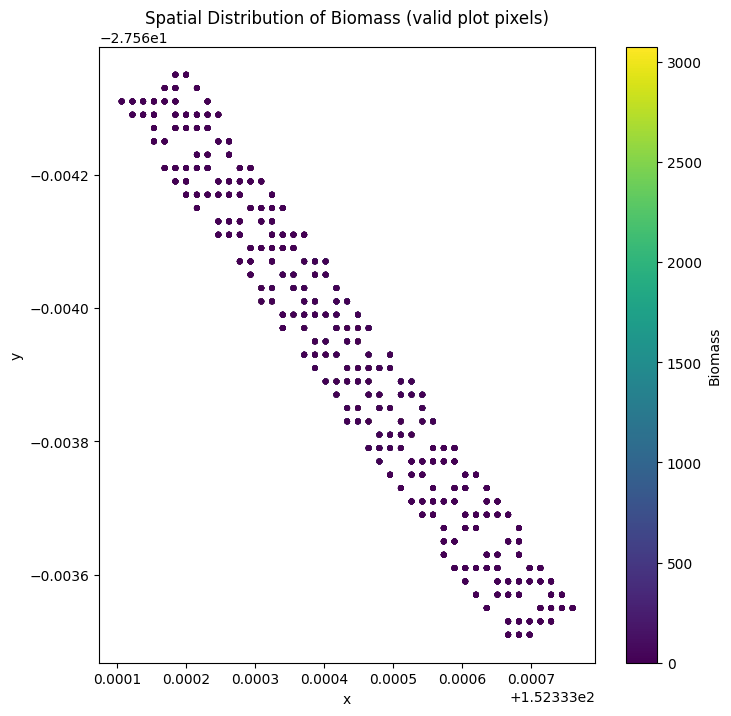

In [8]:
plt.figure(figsize=(8, 8))
plt.scatter(df_valid['x'], df_valid['y'], c=df_valid['main_fw'], cmap='viridis', s=10)
plt.colorbar(label='Biomass')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Spatial Distribution of Biomass (valid plot pixels)')
plt.gca().invert_yaxis()
plt.show()

In [9]:
from scipy.stats import pearsonr

# Prepare a results DataFrame
results = []

for plot_id, group in df_valid.groupby('plot_id'):
    # Only calculate if there are at least 2 non-NaN points (Pearson needs at least 2)
    row = {'plot_id': plot_id}
    for var in ['median_ndvi', 'median_ndre_r', 'median_savi']:
        x = group['main_fw']
        y = group[var]
        mask = (~x.isna()) & (~y.isna())
        if mask.sum() > 1 and x[mask].nunique() > 1 and y[mask].nunique() > 1:
            r, _ = pearsonr(x[mask], y[mask])
            row[f'corr_{var}'] = r
        else:
            row[f'corr_{var}'] = None
    results.append(row)

corr_df = pd.DataFrame(results)

In [10]:
# Calculate per-plot correlations
results = []
for plot_id, group in df_valid.groupby('plot_id'):
    row = {'plot_id': plot_id}
    for var in ['median_ndvi', 'median_ndre_r', 'median_savi']:
        x = group['main_fw']
        y = group[var]
        mask = (~x.isna()) & (~y.isna())
        if mask.sum() > 1 and x[mask].nunique() > 1 and y[mask].nunique() > 1:
            r, _ = pearsonr(x[mask], y[mask])
            row[f'corr_{var}'] = r
        else:
            row[f'corr_{var}'] = None
    results.append(row)
corr_df = pd.DataFrame(results)

# Calculate centroids (only x, y)
centroids = df_valid.groupby('plot_id')[['x', 'y']].median().reset_index()

# Get per-plot biomass summary (e.g., mean, latest, etc.)
# Example: mean biomass per plot
biomass = df_valid.groupby('plot_id')[['main_fw']].mean().reset_index()

# Merge all together
plot_map = centroids.merge(biomass, on='plot_id').merge(corr_df, on='plot_id')


## Data Analysis/Visualisation

     plot_id           x         y     main_fw  corr_median_ndvi  \
0        1.0  152.333114 -27.56430  123.958571          0.167819   
1        2.0  152.333138 -27.56430  121.150952          0.160813   
2        3.0  152.333153 -27.56431  140.868095          0.174063   
3        4.0  152.333169 -27.56431  142.931429          0.174178   
4        5.0  152.333184 -27.56434  127.660000          0.164457   
..       ...         ...       ...         ...               ...   
103    104.0  152.333682 -27.56352   98.254091         -0.583111   
104    105.0  152.333698 -27.56353  104.098636         -0.607723   
105    106.0  152.333713 -27.56353  121.828182         -0.569424   
106    107.0  152.333729 -27.56355  111.050909         -0.578019   
107    108.0  152.333752 -27.56356  115.950455         -0.563396   

     corr_median_ndre_r  corr_median_savi  
0              0.251298          0.258050  
1              0.232625          0.319272  
2              0.267858          0.309489  
3      

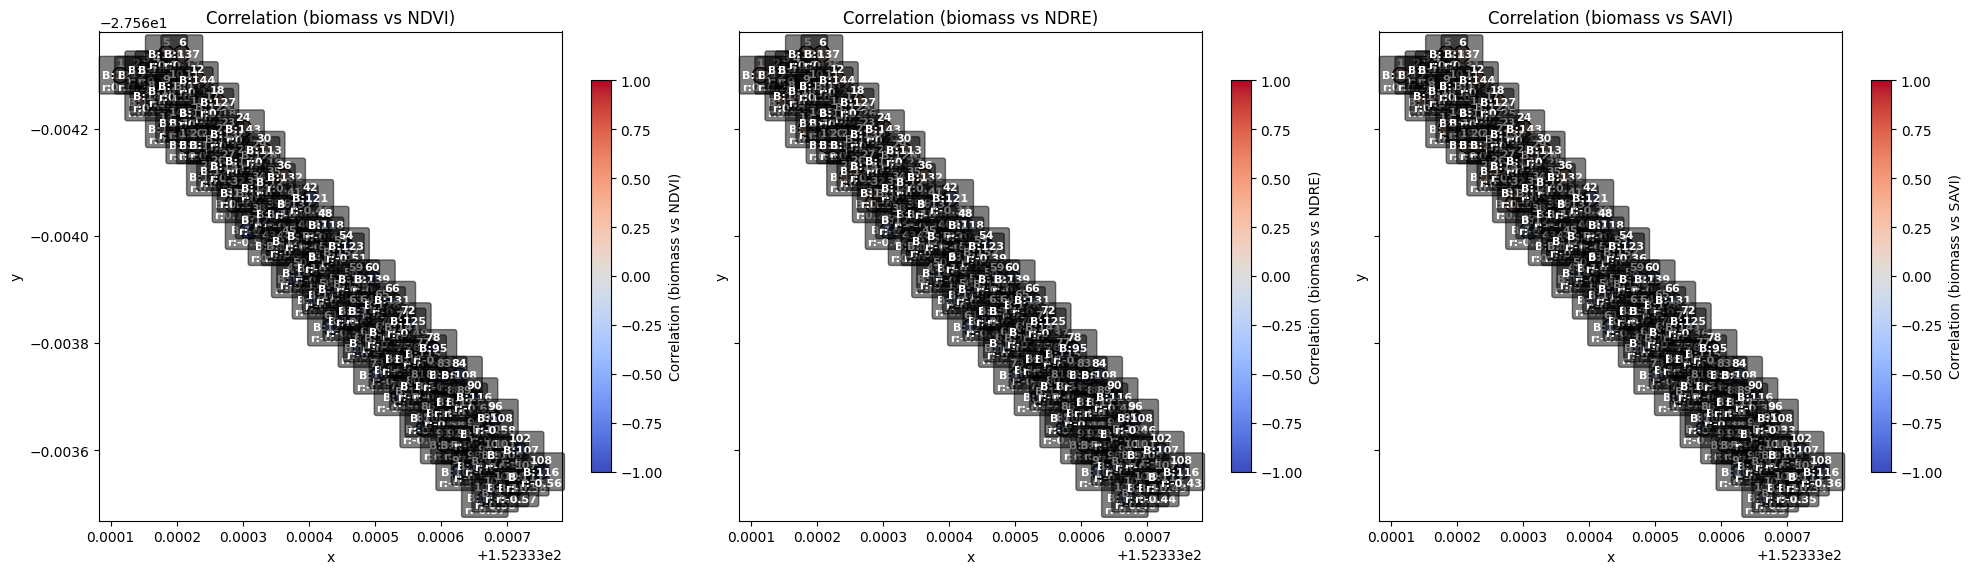

In [11]:
import matplotlib.pyplot as plt

corr_vars = [
    ('corr_median_ndvi', 'NDVI'),
    ('corr_median_ndre_r', 'NDRE'),
    ('corr_median_savi', 'SAVI')
]

fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharex=True, sharey=True)

print(plot_map)

for ax, (corr_var, var_label) in zip(axes, corr_vars):
    sc = ax.scatter(
        plot_map['x'], plot_map['y'],
        c=plot_map[corr_var],
        s=plot_map['main_fw'],
        cmap='coolwarm', vmin=-1, vmax=1, edgecolor='k'
    )
    ax.set_title(f'Correlation (biomass vs {var_label})')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.invert_yaxis()
    plt.colorbar(sc, ax=ax, label=f'Correlation (biomass vs {var_label})', shrink=0.8)
    for _, row in plot_map.iterrows():
        ax.text(
            row['x'], row['y'],
            f"{int(row['plot_id'])}\nB:{row['main_fw']:.0f}\nr:{row[corr_var]:.2f}" if not pd.isna(row[corr_var]) else f"{int(row['plot_id'])}\nB:{row['main_fw']:.0f}\nr:NA",
            ha='center', va='center', color='white', fontsize=8, fontweight='bold',
            bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.2')
        )

plt.tight_layout()
plt.show()

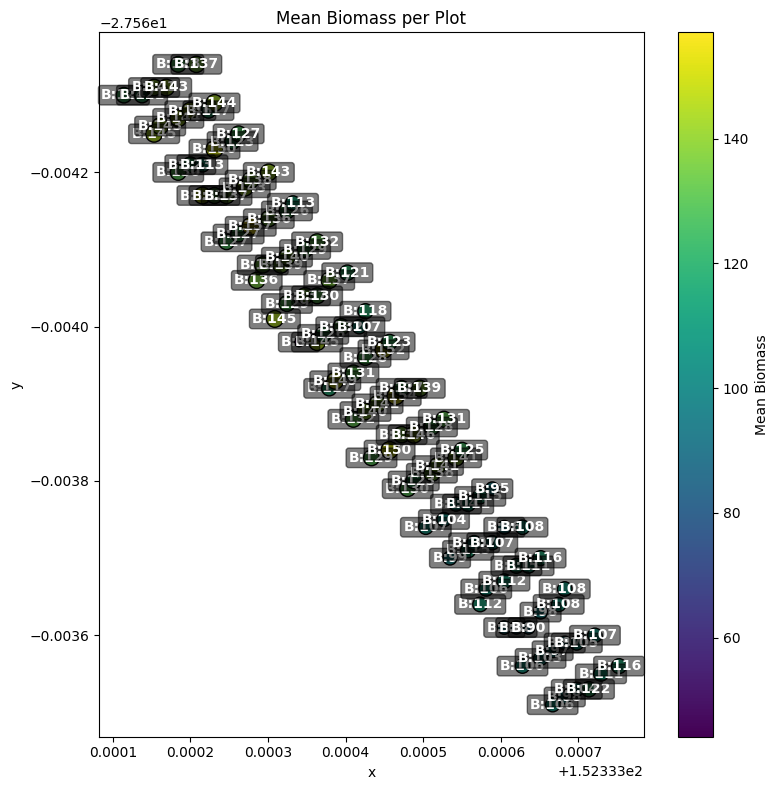

In [12]:
fig, ax = plt.subplots(figsize=(8, 8))

sc = ax.scatter(
    plot_map['x'], plot_map['y'],
    c=plot_map['main_fw'],
    s=plot_map['main_fw'],
    cmap='viridis', edgecolor='k'
)
plt.colorbar(sc, ax=ax, label='Mean Biomass')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Mean Biomass per Plot')
ax.invert_yaxis()

for _, row in plot_map.iterrows():
    ax.text(
        row['x'], row['y'],
        f"B:{row['main_fw']:.0f}",
        ha='center', va='center', color='white', fontsize=10, fontweight='bold',
        bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.2')
    )

plt.tight_layout()
plt.show()

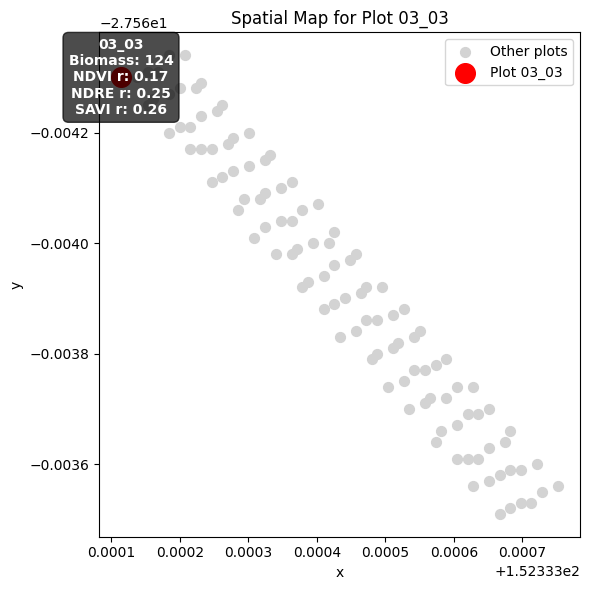

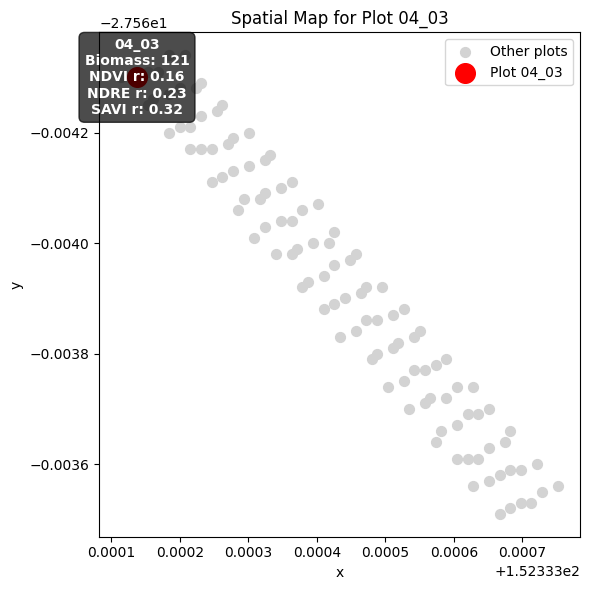

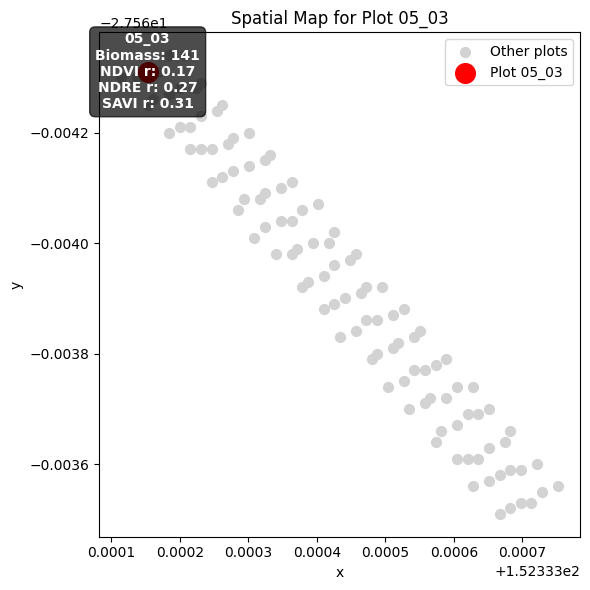

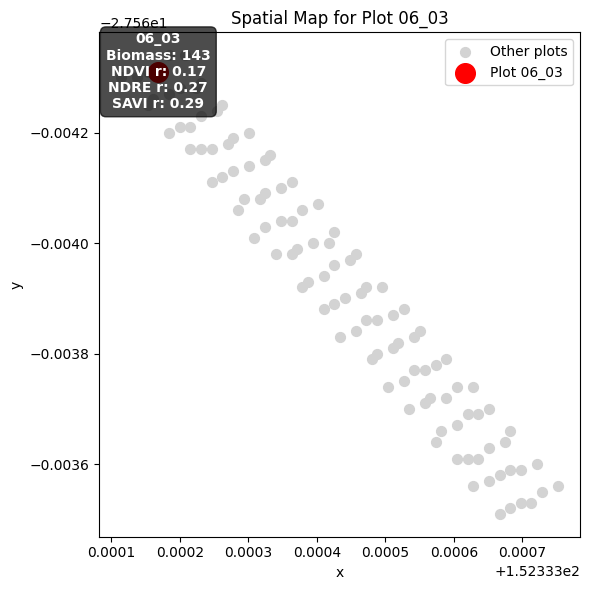

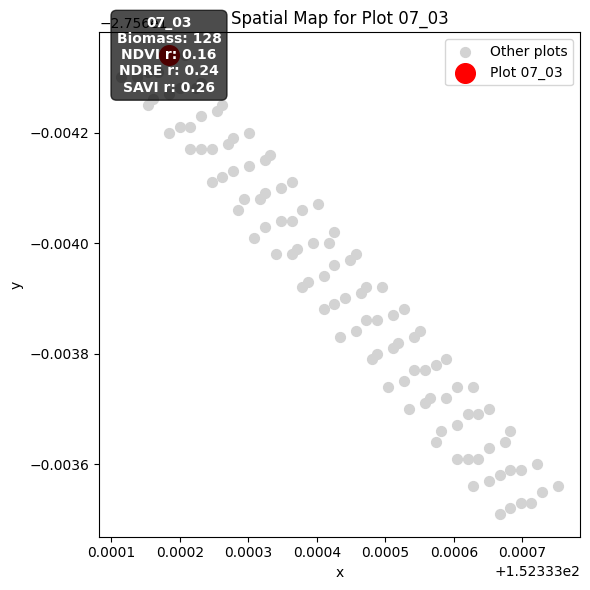

In [13]:
plot_id_to_name = {
    1: '03_03',
    2: '04_03',
    3: '05_03',
    4: '06_03',
    5: '07_03',
}

selected_plots = [1, 2, 3, 4, 5] 

for plot_id in selected_plots:
    row = plot_map[plot_map['plot_id'] == plot_id]
    if row.empty:
        print(f"Plot {plot_id} not found in plot_map.")
        continue

    plot_name = plot_id_to_name.get(int(plot_id), f"ID {int(plot_id)}")

    plt.figure(figsize=(6, 6))
    # Show all other plots as gray for context
    plt.scatter(plot_map['x'], plot_map['y'], c='lightgray', s=50, label='Other plots')
    # Highlight the selected plot
    plt.scatter(row['x'], row['y'], c='red', s=200, label=f'Plot {plot_name}')
    
    # Annotate with mean biomass and correlations
    label = (
        f"{plot_name}\n"
        f"Biomass: {row['main_fw'].values[0]:.0f}\n"
        f"NDVI r: {row['corr_median_ndvi'].values[0]:.2f}\n"
        f"NDRE r: {row['corr_median_ndre_r'].values[0]:.2f}\n"
        f"SAVI r: {row['corr_median_savi'].values[0]:.2f}"
    )
    plt.text(
        row['x'].values[0], row['y'].values[0], label,
        ha='center', va='center', color='white', fontsize=10, fontweight='bold',
        bbox=dict(facecolor='black', alpha=0.7, boxstyle='round,pad=0.4')
    )
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f'Spatial Map for Plot {plot_name}')
    plt.legend()
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

## Correlation of Biomass vs SAVI in early season, Biomass vs NDVI in mid season and Biomass vs NDRE in late season

/var/folders/7j/dlqz_jld5qbf973v3__6xlnh0000gq/T/ipykernel_59361/645108648.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['date'] = pd.to_datetime(df_valid['time'])


Season Dates and Correlation Variables:
Early season: 2022-07-28 | Correlation: SAVI vs Biomass
Mid season: 2022-08-08 | Correlation: NDVI vs Biomass
Late season: 2022-09-18 | Correlation: NDRE vs Biomass


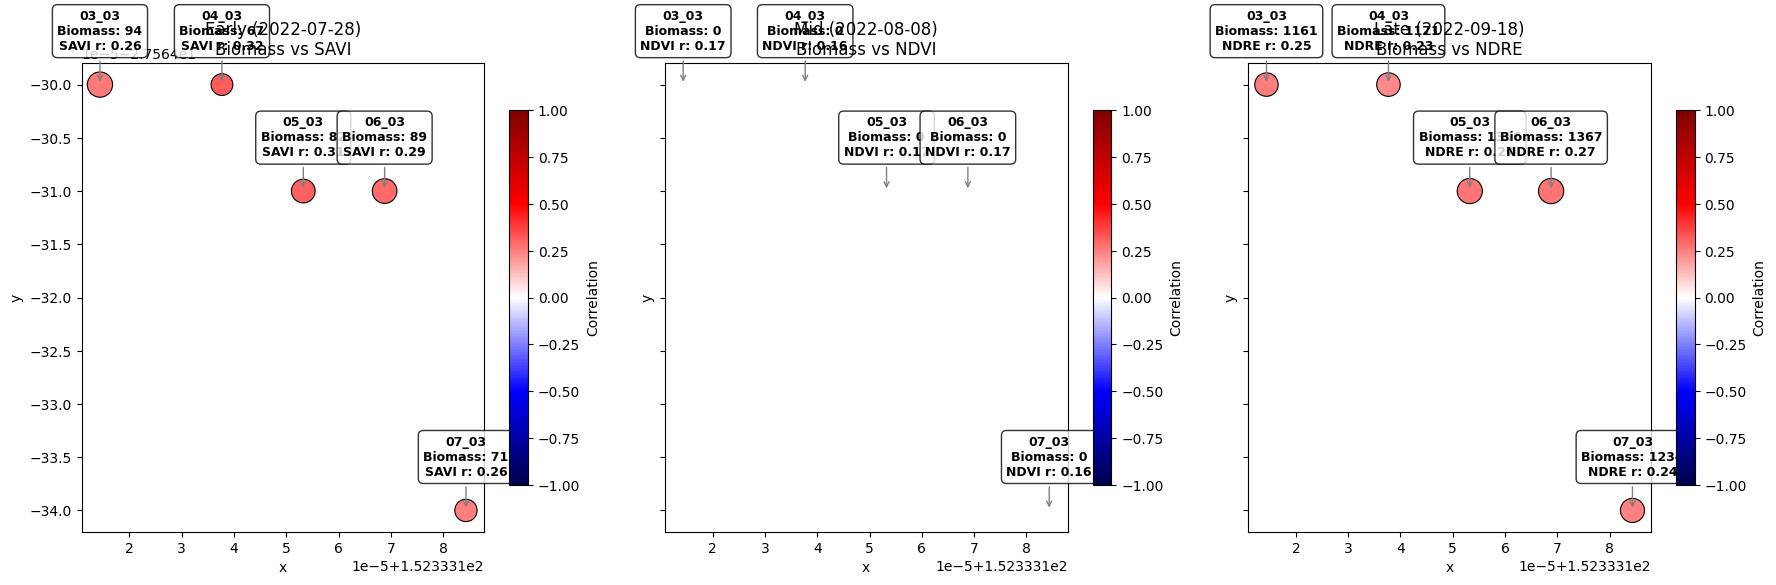

In [14]:

df_valid['date'] = pd.to_datetime(df_valid['time'])

# Mapping from plot_id to readable names
plot_id_to_name = {
    1: '03_03',
    2: '04_03',
    3: '05_03',
    4: '06_03',
    5: '07_03',
}

selected_plots = [1, 2, 3, 4, 5]

# Season metadata
season_info = [
    ('Early', 'median_savi', 'SAVI', '2022-07-28'),
    ('Mid', 'median_ndvi', 'NDVI', '2022-08-08'),
    ('Late', 'median_ndre_r', 'NDRE', '2022-09-18')
]

print("Season Dates and Correlation Variables:")
for season, var, var_label, date in season_info:
    print(f"{season} season: {date} | Correlation: {var_label} vs Biomass")

# Subset plot_map for selected plots
subset = plot_map[plot_map['plot_id'].isin(selected_plots)][['plot_id', 'x', 'y']]

# X/Y bounds for plotting
x_min, x_max = subset['x'].min(), subset['x'].max()
y_min, y_max = subset['y'].min(), subset['y'].max()
x_margin = (x_max - x_min) * 0.05
y_margin = (y_max - y_min) * 0.05

# Create figure
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

for ax, (season, corr_var, var_label, date_str) in zip(axes, season_info):
    date = pd.to_datetime(date_str)
    date_range = (df_valid['date'] >= date - pd.Timedelta(days=7)) & (df_valid['date'] <= date + pd.Timedelta(days=7))

    # Filter for biomass in time window
    biomass_df = df_valid[date_range & df_valid['plot_id'].isin(selected_plots)]
    biomass_summary = biomass_df.groupby('plot_id')['main_fw'].mean().reset_index()

    # Merge with plot coordinates and correlation
    merged = pd.merge(subset, biomass_summary, on='plot_id', how='left')
    merged = pd.merge(merged, plot_map[['plot_id', f'corr_{corr_var}']], on='plot_id', how='left')

    # Plot points
    sc = ax.scatter(
        merged['x'], merged['y'],
        c=merged[f'corr_{corr_var}'],
        s=merged['main_fw'] / merged['main_fw'].max() * 300 + 30,
        cmap='seismic',  # or 'bwr'
        vmin=-1, vmax=1,
        edgecolor='black',
        linewidth=0.8
)


    # Add annotated labels with offset and arrow
    for _, row in merged.iterrows():
        plot_name = plot_id_to_name.get(int(row['plot_id']), f"ID {int(row['plot_id'])}")
        corr_val = row[f'corr_{corr_var}']
        biomass = row['main_fw']
        label = (
            f"{plot_name}\nBiomass: {biomass:.0f}\n{var_label} r: {corr_val:.2f}"
            if pd.notna(corr_val)
            else f"{plot_name}\nBiomass: {biomass:.0f}\n{var_label} r: NA"
        )

        x, y = row['x'], row['y']
        offset = y_margin * 1.5

        ax.annotate(
            label,
            xy=(x, y),
            xytext=(x, y + offset),
            textcoords='data',
            ha='center', va='bottom',
            fontsize=9, fontweight='bold',
            color='black',
            bbox=dict(boxstyle='round,pad=0.4', fc='white', ec='black', alpha=0.8),
            arrowprops=dict(arrowstyle='->', color='gray', lw=1)
        )

    # Plot settings
    ax.set_title(f'{season} ({date_str})\nBiomass vs {var_label}')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.invert_yaxis()
    ax.set_xlim(x_min - x_margin, x_max + x_margin)
    ax.set_ylim(y_min - y_margin, y_max + y_margin)
    plt.colorbar(sc, ax=ax, label='Correlation', shrink=0.8)

plt.tight_layout()
plt.show()


/var/folders/7j/dlqz_jld5qbf973v3__6xlnh0000gq/T/ipykernel_59361/3460500753.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['date'] = pd.to_datetime(df_valid['date'])


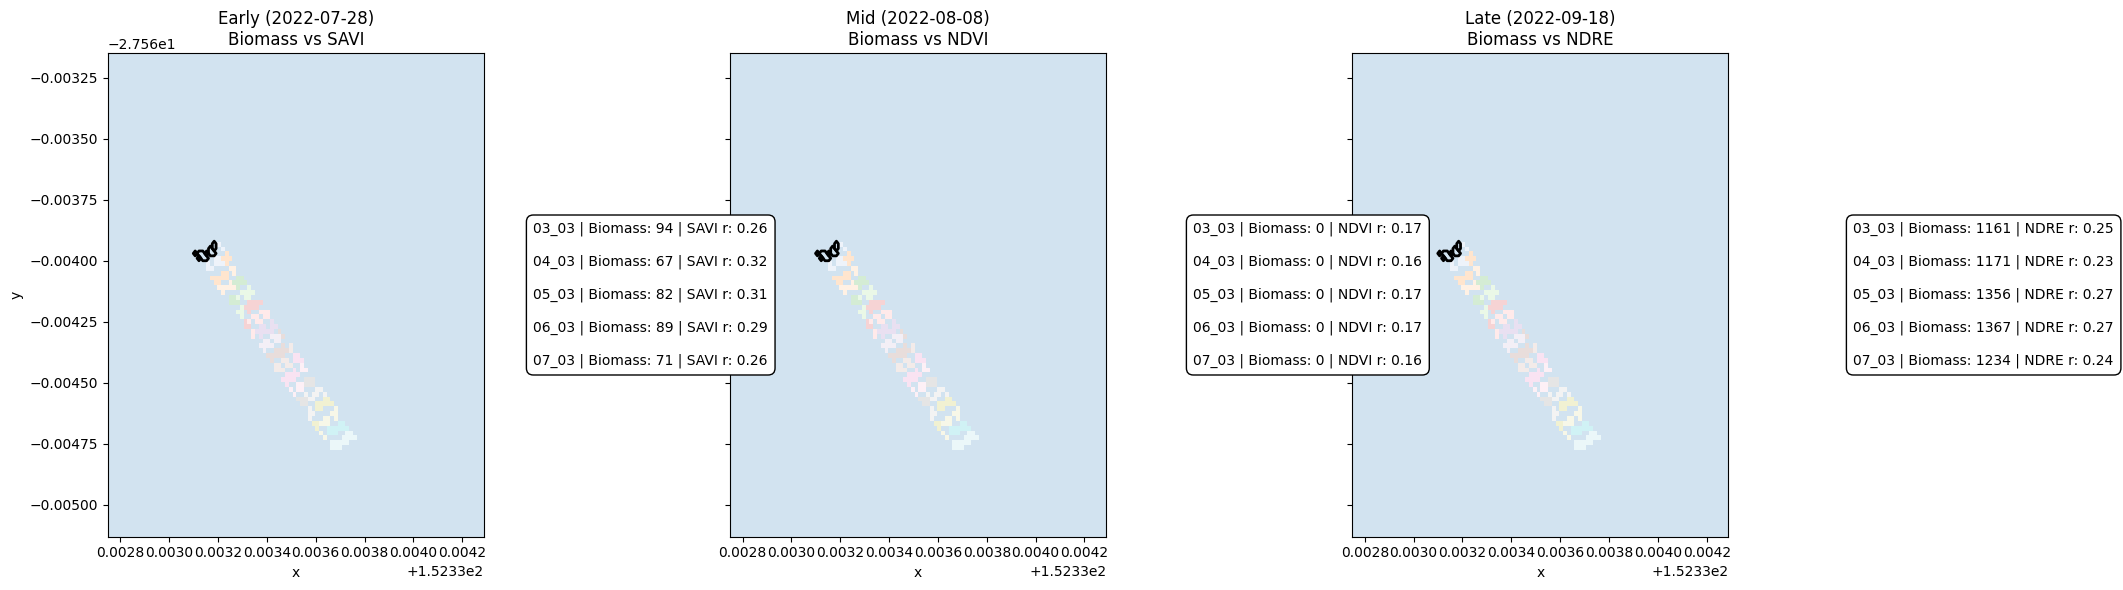

In [15]:
if 'date' not in df_valid.columns and 'time' in df_valid.columns:
    df_valid = df_valid.rename(columns={'time': 'date'})
df_valid['date'] = pd.to_datetime(df_valid['date'])

selected_plots = [1, 2, 3, 4, 5]
plot_mask = raw_ds['plot_id'].isel(time=0).values
x_coords = raw_ds['x'].values
y_coords = raw_ds['y'].values

season_info = [
    ('Early', 'median_savi', 'SAVI', '2022-07-28'),
    ('Mid', 'median_ndvi', 'NDVI', '2022-08-08'),
    ('Late', 'median_ndre_r', 'NDRE', '2022-09-18')
]

fig, axes = plt.subplots(1, 3, figsize=(20, 6), gridspec_kw={'width_ratios': [3, 3, 3]}, sharex=True, sharey=True)

for ax, (season, corr_var, var_label, date_str) in zip(axes, season_info):
    annotations = []
    date = pd.to_datetime(date_str)
    window_start = date - pd.Timedelta(days=7)
    window_end = date + pd.Timedelta(days=7)

    # Get biomass per plot in ±2-day window
    biomass_window = df_valid[
        df_valid['plot_id'].isin(selected_plots) &
        (df_valid['date'] >= window_start) &
        (df_valid['date'] <= window_end)
    ]
    biomass_per_plot = biomass_window.groupby('plot_id')['main_fw'].mean()

    im = ax.imshow(plot_mask, cmap='tab20', alpha=0.2, origin='lower',
                   extent=[x_coords.min(), x_coords.max(), y_coords.min(), y_coords.max()])

    for plot_id in selected_plots:
        mask = (plot_mask == plot_id)
        if np.any(mask):
            ax.contour(mask, levels=[0.5], colors='k', linewidths=2,
                       extent=[x_coords.min(), x_coords.max(), y_coords.min(), y_coords.max()])
            y_idx, x_idx = np.where(mask)
            if len(x_idx) > 0 and len(y_idx) > 0:
                x_c = x_coords[x_idx].mean()
                y_c = y_coords[y_idx].mean()
                row = plot_map[plot_map['plot_id'] == plot_id]
                if not row.empty:
                    plot_name = plot_id_to_name.get(int(plot_id), f"ID {int(plot_id)}")
                    biomass = biomass_per_plot.get(plot_id, np.nan)
                    corr_val = row[f'corr_{corr_var}'].values[0]
                    label = (
                        f"{plot_name} | Biomass: {biomass:.0f} | {var_label} r: {corr_val:.2f}"
                        if not np.isnan(corr_val)
                        else f"{plot_name} | Biomass: {biomass:.0f} | {var_label} r: NA"
                    )
                    annotations.append(label)

    ax.set_title(f'{season} ({date_str})\nBiomass vs {var_label}')
    ax.set_xlabel('x')
    ax.set_ylabel('y')

    # Place annotations to the right of the subplot
    ann_text = "\n\n".join(annotations)
    fig.text(0.32 + 0.33 * season_info.index((season, corr_var, var_label, date_str)), 0.5, ann_text,
             va='center', ha='left', fontsize=10, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

plt.tight_layout()
plt.show()


Early Season Analysis (SAVI):


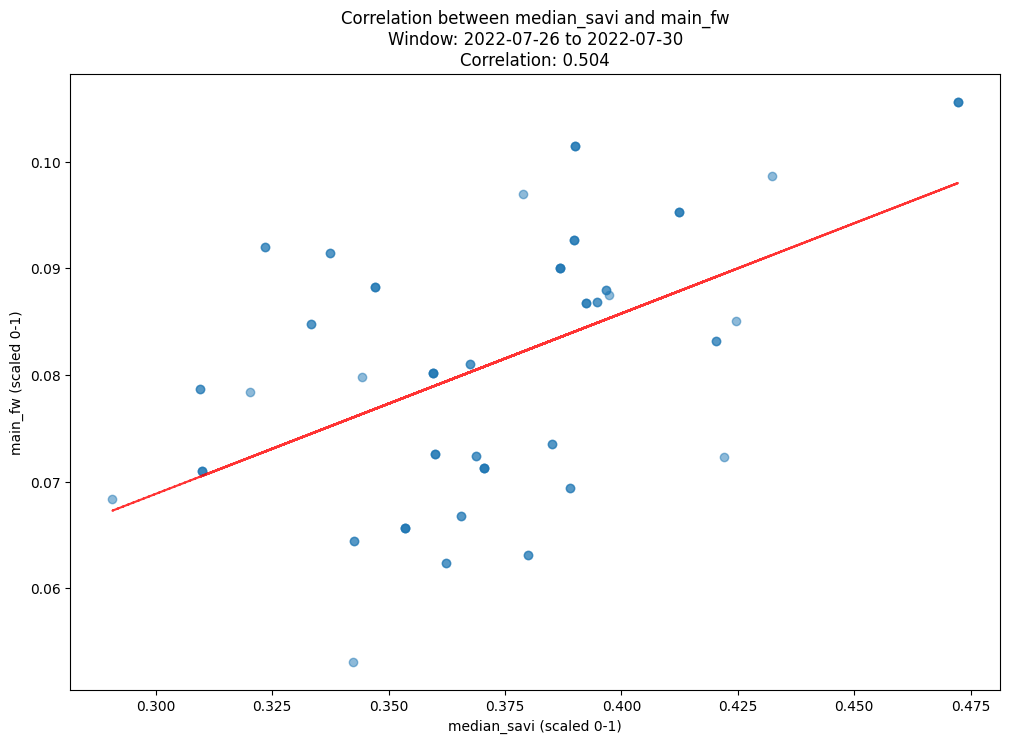


Detailed statistics for window 2022-07-26 to 2022-07-30:
Correlation: 0.504
Number of data points: 79

Value ranges and quartiles:
median_savi:
count    79.000000
mean      0.372249
std       0.036423
min       0.290666
25%       0.350304
50%       0.370473
75%       0.390056
max       0.472288
Name: median_savi, dtype: float64

main_fw:
count    79.000000
mean      0.081073
std       0.012226
min       0.053115
25%       0.071268
50%       0.081073
75%       0.089993
max       0.105642
Name: main_fw, dtype: float64

Statistics by date:

Date: 2022-07-27
Number of points: 79
Correlation: 0.504
median_savi mean: 0.372
main_fw mean: 0.081

Mid Season Analysis (NDVI):


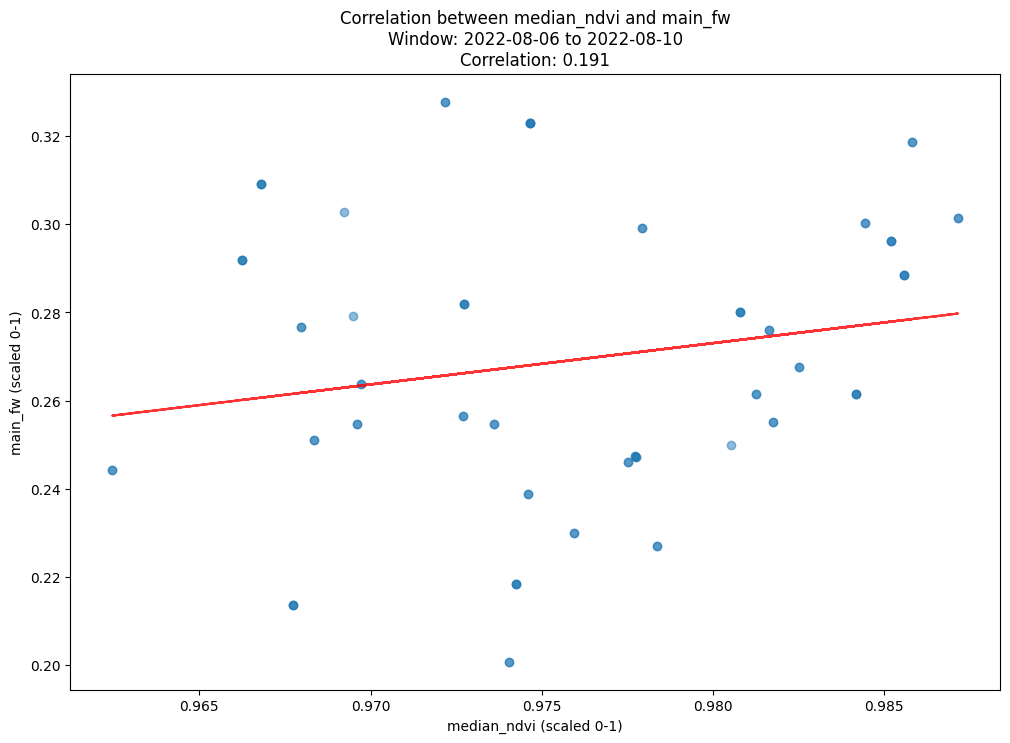


Detailed statistics for window 2022-08-06 to 2022-08-10:
Correlation: 0.191
Number of data points: 80

Value ranges and quartiles:
median_ndvi:
count    80.000000
mean      0.975983
std       0.006595
min       0.962462
25%       0.969725
50%       0.974657
75%       0.981624
max       0.987153
Name: median_ndvi, dtype: float64

main_fw:
count    80.000000
mean      0.269268
std       0.032423
min       0.200815
25%       0.247316
50%       0.265709
75%       0.296183
max       0.327809
Name: main_fw, dtype: float64

Statistics by date:

Date: 2022-08-07
Number of points: 80
Correlation: 0.191
median_ndvi mean: 0.976
main_fw mean: 0.269

Late Season Analysis (NDRE):


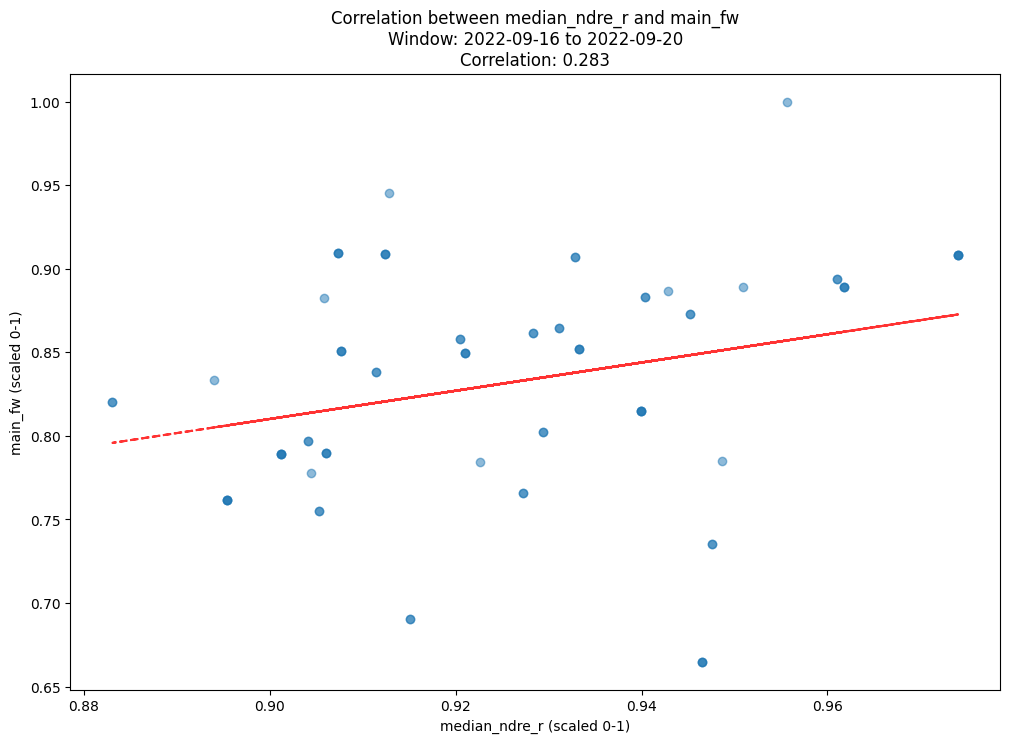


Detailed statistics for window 2022-09-16 to 2022-09-20:
Correlation: 0.283
Number of data points: 79

Value ranges and quartiles:
median_ndre_r:
count    79.000000
mean      0.925748
std       0.022832
min       0.883096
25%       0.906691
50%       0.922660
75%       0.941610
max       0.974028
Name: median_ndre_r, dtype: float64

main_fw:
count    79.000000
mean      0.831865
std       0.068258
min       0.664994
25%       0.789146
50%       0.849399
75%       0.887978
max       1.000000
Name: main_fw, dtype: float64

Statistics by date:

Date: 2022-09-17
Number of points: 79
Correlation: 0.283
median_ndre_r mean: 0.926
main_fw mean: 0.832


<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [16]:

from datetime import timedelta

# Convert to DataFrame
df = raw_ds.to_dataframe().reset_index()

# Function to scale values to 0-1
def scale_to_0_1(series):
    return (series - series.min()) / (series.max() - series.min())

# Scale the vegetation indices and biomass
columns_to_scale = ['median_savi', 'median_ndvi', 'median_ndre_r', 'main_fw']
for col in columns_to_scale:
    df[col] = scale_to_0_1(df[col])

# Remove rows where any of the columns have 0 values
df = df[df[columns_to_scale].ne(0).all(axis=1)]

# Define the target dates
target_dates = {
    'early': '2022-07-28',
    'mid': '2022-08-08',
    'late': '2022-09-18'
}

# Function to analyze correlations for a date window
def analyze_season_correlation(target_date, index_col, target_col='main_fw', window_days=2):
    # Convert target date to datetime
    target_dt = pd.to_datetime(target_date)
    
    # Create date range
    start_date = target_dt - timedelta(days=window_days)
    end_date = target_dt + timedelta(days=window_days)
    
    # Filter data for the date window
    date_data = df[(df['time'].dt.date >= start_date.date()) & 
                   (df['time'].dt.date <= end_date.date())]
    
    # Remove rows where either column has NaN
    date_data = date_data.dropna(subset=[index_col, target_col])
    
    # Calculate correlation
    correlation = date_data[index_col].corr(date_data[target_col])
    
    # Create scatter plot with regression line
    plt.figure(figsize=(12, 8))
    plt.scatter(date_data[index_col], date_data[target_col], alpha=0.5)
    
    # Add regression line
    z = np.polyfit(date_data[index_col], date_data[target_col], 1)
    p = np.poly1d(z)
    plt.plot(date_data[index_col], p(date_data[index_col]), "r--", alpha=0.8)
    
    plt.title(f'Correlation between {index_col} and {target_col}\nWindow: {start_date.date()} to {end_date.date()}\nCorrelation: {correlation:.3f}')
    plt.xlabel(f'{index_col} (scaled 0-1)')
    plt.ylabel(f'{target_col} (scaled 0-1)')
    plt.show()
    
    # Print detailed statistics
    print(f"\nDetailed statistics for window {start_date.date()} to {end_date.date()}:")
    print(f"Correlation: {correlation:.3f}")
    print(f"Number of data points: {len(date_data)}")
    
    # Print value ranges and quartiles
    print(f"\nValue ranges and quartiles:")
    print(f"{index_col}:")
    print(date_data[index_col].describe())
    print(f"\n{target_col}:")
    print(date_data[target_col].describe())
    
    # Print statistics by date
    print("\nStatistics by date:")
    for date in date_data['time'].dt.date.unique():
        date_stats = date_data[date_data['time'].dt.date == date]
        print(f"\nDate: {date}")
        print(f"Number of points: {len(date_stats)}")
        print(f"Correlation: {date_stats[index_col].corr(date_stats[target_col]):.3f}")
        print(f"{index_col} mean: {date_stats[index_col].mean():.3f}")
        print(f"{target_col} mean: {date_stats[target_col].mean():.3f}")
    
    return correlation, date_data

# Analyze each season
print("Early Season Analysis (SAVI):")
early_corr, early_data = analyze_season_correlation(target_dates['early'], 'median_savi')

print("\nMid Season Analysis (NDVI):")
mid_corr, mid_data = analyze_season_correlation(target_dates['mid'], 'median_ndvi')

print("\nLate Season Analysis (NDRE):")
late_corr, late_data = analyze_season_correlation(target_dates['late'], 'median_ndre_r')

# Compare correlations across seasons
correlations = {
    'Early (SAVI)': early_corr,
    'Mid (NDVI)': mid_corr,
    'Late (NDRE)': late_corr
}

plt.figure(figsize=(10, 6))